In [1]:
import numpy as np
from scipy.stats import norm
import numpy as np
import astropy
from astropy.io import fits
from astropy import units as u
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import healpy as hp
import pandas as pd
import math
import scipy
import statistics as st
from scipy import stats
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image

%matplotlib inline

NSIDE=2048
Npix=12*NSIDE**2

pi=math.pi

import warnings
warnings.filterwarnings('ignore')

---

### Read in MMF3

In [2]:
amfFull = pd.read_csv('amfFull.tsv',sep='|')

c = SkyCoord(amfFull['RAJ2000'],amfFull['DEJ2000'],frame='icrs',unit='deg')

amfFull['GLAT'] = c.galactic.b.degree
amfFull['GLON'] = c.galactic.l.degree

amfFull['GLAT'] = np.around(amfFull['GLAT'].values,1)
amfFull['GLON'] = np.around(amfFull['GLON'].values,1)
print(amfFull.iloc[0,11]) # glat
print(amfFull.iloc[0,12]) # glon
amfFull

-40.9
136.7


,ID,AMF9,RAJ2000,DEJ2000,z,Lk,Lambda200,r200,rc,c,str-rh,GLAT,GLON
0,4,J013539.1+204447,23.9128,20.7465,0.0601,176.9125,219.3663,1.946,0.925,2.104,73.0001,-40.9,136.7
1,5,J172231.8+320823,260.6324,32.1398,0.2252,222.1219,200.7117,1.784,0.625,2.856,35.0001,31.8,55.6
2,6,J131131.1-012008,197.8796,-1.3356,0.2042,171.6872,192.0829,1.773,0.227,7.792,9.0001,61.1,313.4
3,7,J164035.6+464130,250.1485,46.6917,0.2248,225.9874,182.3373,1.725,0.495,3.483,36.0001,41.4,72.6
4,8,J230521.6+210216,346.3402,21.0378,0.1453,121.0124,182.2769,1.775,0.440,4.034,72.0001,-35.4,92.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46474,54273,J212414.7-053519,321.0614,-5.5885,0.4036,7.3319,20.0008,0.734,0.260,2.823,85.1216,-36.3,46.9
46475,54274,J104720.5-025526,161.7603,-2.9238,0.2064,11.9584,20.0006,0.790,0.090,8.781,9.1111,47.5,253.1
46476,54275,J213855.7+153523,324.7319,15.5898,0.1964,8.6750,20.0005,0.793,0.180,4.404,73.0886,-26.7,69.5
46477,54276,J085114.6+015313,132.8109,1.8870,0.2697,12.2539,20.0002,0.772,0.260,2.971,12.1012,27.3,225.8


### Check against union mask

In [29]:
mask = hp.read_map('HFI_PCCS_SZ-selfunc-union-survey_2.02.fits')

# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[((maskedArray.glat > 10)|((maskedArray.glat<-10) & ((maskedArray.glon<210)))) | ((maskedArray.glat>0) & ((maskedArray.glon<240)&(maskedArray.glon>180)))].reset_index()

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


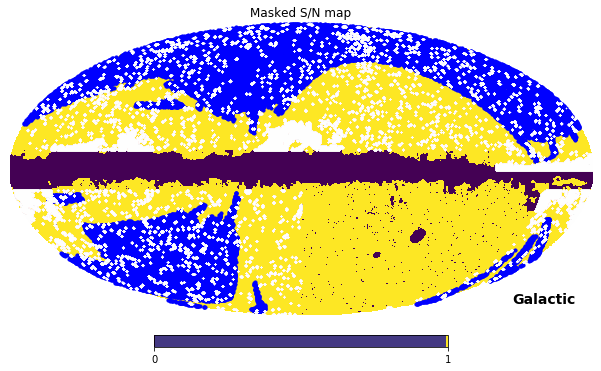

In [30]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='b',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)

In [31]:
# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[(maskedArray.glat > 15)|((maskedArray.glat<-15) & ((maskedArray.glon<210)))].reset_index()

In [ ]:
unionLons = []
unionLats = []

for i in range(amfFull.shape[0]):
    matchFlag=False
    for j in range(11): # Within 1 degree
        print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
        if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]+j/10, maskedArray.glat == amfFull.iloc[i][11]+j/10)].empty:
            print("MATCH")
            matchFlag=True
            unionLons.append(amfFull.iloc[i][12])
            unionLats.append(amfFull.iloc[i][11])
            break
    if not matchFlag:
        for j in range(11): # Within 1 degree
            print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
            if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]-j/10, maskedArray.glat == amfFull.iloc[i][11]-j/10)].empty:
                print("MATCH")
                matchFlag=True
                unionLons.append(amfFull.iloc[i][12])
                unionLats.append(amfFull.iloc[i][11])
                break
masked = pd.DataFrame({'glon': unionLons, 'glat': unionLats})

0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
MATCH
4 92.2 -35.4
MATCH
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5

31 231.6 60.0
31 231.6 60.0
31 231.6 60.0
31 231.6 60.0
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
35 155.2 -14.6
35 15

62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 9

90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
91 58.7 -46.7
MATCH
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 12

119 84.2 -25.1
119 84.2 -25.1
119 84.2 -25.1
119 84.2 -25.1
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
12

146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
14

174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 

200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
MATCH
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
MATCH
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
20

229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
230 228.5 57.9
MATCH
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 

258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71

285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.

313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
31

342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
345

368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 

395 166.9 -46.2
395 166.9 -46.2
395 166.9 -46.2
395 166.9 -46.2
MATCH
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.

421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
421 142.6 -13.7
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
422 61.4 -47.2
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
423 153.7 41.0
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
424 70.3 -39.3
42

448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
448 87.1 -41.7
MATCH
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
449 98.4 -67.6
MATCH
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
450 133.0 -47.5
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 197.2 45.2
451 19

477 62.4 -45.6
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
478 32.2 60.7
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
479 145.8 41.6
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
480 228.8 34.5
481 156.6 -14.8
4

503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
503 164.3 -47.8
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
504 169.6 69.5
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
505 119.6 -72.1
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9 35.0
506 93.9

529 177.3 76.0
529 177.3 76.0
529 177.3 76.0
529 177.3 76.0
529 177.3 76.0
529 177.3 76.0
530 73.8 37.9
530 73.8 37.9
530 73.8 37.9
MATCH
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
531 109.9 52.9
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
532 79.3 -22.2
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70.5 64.4
533 70

559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
559 155.5 68.5
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
560 56.1 36.2
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
561 216.5 78.4
562 4.0 42.2
562 4.0 42.2
562 4.0 42.2
562 4.0 42.2
562 4.0 42.2
562 4.0 42.2

585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
585 161.7 -64.2
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
586 93.3 53.1
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
587 107.4 68.0
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6 65.6
588 260.6

612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
612 144.5 62.8
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
613 235.9 33.5
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
614 107.8 -55.1
615 129.7 -29.1
61

641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
641 232.1 70.7
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
642 42.3 43.0
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
643 93.8 -82.7
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.1
644 50.8 57.

667 219.2 44.4
667 219.2 44.4
667 219.2 44.4
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
668 92.3 -49.0
669 298.5 61.7
669 298.5 61.7
669 298.5 61.7
669 298.5 61.7
669 298.5 61.7
MATCH
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
670 215.8 16.8
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 91.9 65.4
671 

696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
696 79.7 81.0
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
697 163.6 -65.1
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
698 227.8 75.0
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 79.6
699 293.1 7

724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
724 64.8 61.8
725 122.6 -30.4
MATCH
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
726 260.0 51.1
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
727 78.6 -43.0
728 224.7 53.0
728 224.7 53.0
728 224.7 53.0
728 224.7 53.0
728 224.7 53.0
728 224.7 53.0
728 224.7 53.0
728

753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
753 149.9 -54.0
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
754 225.2 76.4
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.6
755 162.2 -63.

780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
780 286.7 83.0
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
781 71.3 -57.3
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
782 345.4 53.4
783 19.9 39.2
783 19.9 39.2
783 19.9 39.2
783 19.9 39.2
783 19.9 39.2
783 19.9 39.2
7

806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
806 170.2 79.1
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
807 68.8 43.7
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
808 42.2 60.9
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6 55.5
809 249.6

834 117.7 59.6
834 117.7 59.6
834 117.7 59.6
834 117.7 59.6
834 117.7 59.6
834 117.7 59.6
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
835 55.7 60.1
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
836 144.2 -29.4
MATCH
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
837 101.9 -28.0
838 209.0 36.3
838 209.0 36.3
838 20

861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
861 116.3 -36.3
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
862 41.6 46.2
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
863 79.2 57.0
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3
864 223.2 18.3


888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
888 60.0 -45.1
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
889 120.7 56.3
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
890 190.2 28.5
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 81.2
891 125.1 

916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
916 54.0 -45.1
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
917 83.2 65.8
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
918 117.7 -52.6
919 251.9 64.9
919 251.9 64.9
919 251.9 64.9
919 251.9 64.9
919 251.9 64.9
919 251.9 

943 103.3 -35.4
943 103.3 -35.4
943 103.3 -35.4
943 103.3 -35.4
MATCH
944 135.6 -44.6
MATCH
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
945 4.3 53.9
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
946 71.0 -60.5
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.5 -64.9
947 75.

970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
970 179.5 40.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
971 190.5 34.1
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
972 156.7 -14.6
MATCH
973 76.9 42.2
973 76.9 42.2
973 76.9 42.2
973 76.9 42.2
973 76

995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
995 273.2 56.6
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
996 143.7 -48.0
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
997 199.3 50.3
998 45.0 65.9
998 45.0 65.9
998 45.0 65.9
998 45.0 65.9
998 45.

1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1020 122.3 52.1
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1021 118.1 -40.4
1022 220.6 39.2
MATCH
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 63.7
1023 116.0 6

1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1045 104.5 52.2
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1046 118.2 -44.4
1047 247.2 44.1
1047 247.2 44.1
1047 247.2 44.1
1047 247.2 44.1
1047 247.2 44.1
MATCH
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 36.8
1048 229.2 3

1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1071 171.4 -48.7
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1072 128.7 61.5
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1073 253.6 72.1
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 84.3 56.7
1074 8

1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1096 73.3 -39.4
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1097 15.2 49.3
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1098 179.5 -43.9
1099 349.1 67.6
1099 349.1 67.6
1099 349

1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1123 76.4 75.0
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1124 129.9 -38.1
1125 119.4 -44.7
MATCH
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 101.8 -49.2
1126 1

1150 109.1 -30.3
1150 109.1 -30.3
1150 109.1 -30.3
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1151 39.2 48.9
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
1152 6.5 37.1
MATCH
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1153 83.8 -54.0
1154 307.0 68.8
1154 307.0 68.8
1154 307.0 68.8
1154 307.0 68.8
1

1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1175 223.7 41.5
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1176 202.1 38.1
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177 126.4 -36.4
1177

1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1200 28.2 31.1
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1201 59.1 57.7
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1202 48.0 54.6
1203 190.8 -38.1
1203 190.8 -38.1
1203 190.8 -38.1
1203 190.8 -38.1
1203 190.8 -38.1
1203 190.8 -38.1
1203 190.8 -3

1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1225 56.8 49.7
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1226 175.3 -47.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 131.3 -57.3
1227 13

1249 79.8 63.5
1249 79.8 63.5
1249 79.8 63.5
1249 79.8 63.5
1249 79.8 63.5
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1250 4.2 56.8
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1251 95.3 48.3
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0
1252 356.6 53.0

1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
1275 156.1 -14.4
MATCH
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1276 103.3 -57.3
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1277 137.0 -48.6
1278 175.8 -46.9
1278 175.8 -46.9
1278 175.8 -46.9
1278 175.8 -46.9
1278 175.8 -46.9
1278 175

1301 339.5 63.6
1301 339.5 63.6
1301 339.5 63.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1302 25.4 82.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1303 209.0 28.6
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4
1304 27.4 33.4


1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1330 169.9 69.3
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1331 91.4 61.4
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
1332 106.1 75.0
MATCH
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.0 31.3
1333 48.

1354 168.1 69.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1355 184.3 29.1
1356 12.5 35.5
MATCH
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1357 138.1 -40.3
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49.4
1358 16.8 49

1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1383 20.0 38.0
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1384 168.0 -46.7
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
1385 164.8 -68.0
MATCH
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 84.7 -25.6
1386 

1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
1408 126.5 56.6
MATCH
1409 236.7 38.8
MATCH
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
1410 210.3 18.2
MATCH
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1411 263.8 80.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
1412 118.4 -27.8
14

1435 200.0 80.9
1435 200.0 80.9
1435 200.0 80.9
MATCH
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1436 336.4 65.1
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1437 40.7 33.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3 70.9
1438 23.3

1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1460 183.0 -43.1
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1461 117.7 -40.7
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1462 96.8 -45.9
1463 287.0 81.1
146

1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1485 227.4 54.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1486 57.3 -29.7
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.5 -40.0
1487 95.

1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1511 196.7 60.2
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1512 92.0 -80.5
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1513 71.5 -59.1
1514 163

1534 101.8 -38.6
1534 101.8 -38.6
1534 101.8 -38.6
1534 101.8 -38.6
1534 101.8 -38.6
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1535 93.2 -32.4
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
1536 208.3 19.5
MATCH
1537 94.5 -36.3
MATCH
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 172.3 -63.1
1538 17

1563 78.4 -24.7
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1564 41.6 51.0
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1565 58.1 51.3
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566 56.1 -71.6
1566

1589 183.9 79.4
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1590 106.5 -53.5
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1591 219.9 36.4
1592 173.3 69.4
1592 173.3 69.4
1592 173.3 69.4
1592 173.3 69.4
1592 173.3 69.4
1592 173.3 69.4
MATCH
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 53.0
1593 109.9 5

1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1615 102.6 -29.7
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1616 26.4 40.4
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1617 220.6 26.8
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -54.2
1618 111.8 -

1640 329.2 57.6
1640 329.2 57.6
1640 329.2 57.6
1640 329.2 57.6
1640 329.2 57.6
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1641 65.1 -61.1
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1642 47.4 64.0
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.9
1643 75.7 46.

1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1665 211.7 37.2
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1666 255.5 50.0
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667 153.4 -12.7
1667

1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1688 78.5 40.6
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
1689 97.8 -37.4
MATCH
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1690 175.2 -55.4
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 110.3 -36.7
1691 1

1713 140.1 -42.6
1713 140.1 -42.6
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1714 44.1 -21.2
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1715 114.8 57.3
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29.8 61.4
1716 29

1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
1740 122.8 -32.4
MATCH
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
1741 100.2 -37.4
MATCH
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1742 77.1 -22.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 115.8 -36.0
1743 11

1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1767 68.6 -38.2
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1768 148.3 42.7
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1769 90.4 -54.6
1770 217.6 18.5
1770 217.6 18.5
1770 217.6 18.5
1770 217

1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1793 229.2 36.6
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1794 186.5 -51.7
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
1795 88.4 -34.2
17

1819 69.0 -51.1
1819 69.0 -51.1
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1820 44.5 -34.7
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1821 124.9 -36.0
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
1822 45.8 -26.9
18

1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1845 177.0 -55.4
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1846 117.3 -53.1
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0
1847 240.2 56.0

1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1871 50.0 30.1
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1872 237.1 63.3
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
1873 170.7 33.8
MATCH
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45.8
1874 103.2 -45

1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1896 258.5 50.5
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1897 230.0 47.2
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1898 103.7 -38.1
1899 147.0 -40.4
1899 147.0 -40.4


1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1923 120.5 -37.4
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1924 37.3 74.2
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1925 88.4 -62.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 131.1 48.3
1926 1

1947 123.5 -56.9
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1948 175.5 41.6
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1949 148.9 79.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 184.6 41.2
1950 18

1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1973 23.3 65.5
1974 147.3 41.3
MATCH
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1975 5.0 69.6
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1976 177.8 70.7
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 192.2 56.1
1977 1

1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
1999 45.4 34.1
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2000 240.2 56.7
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2001 90.5 -41.8
2002 67.9 -39.5
2002 67.9 

2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2024 181.0 48.5
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2025 118.8 -49.8
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
2026 209.6 68.0
MATCH
2027 150.2 -13.4
2027 150.2 -13.4
2027 150.2 -13.4
2027 150.2 -13.4
2027 150.2 -13.4
2027 150.2 -13.4
2027 1

2048 58.5 -41.1
2048 58.5 -41.1
2048 58.5 -41.1
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2049 226.9 57.6
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2050 227.2 45.5
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260.4 58.7
2051 260

2072 44.2 32.2
2072 44.2 32.2
2072 44.2 32.2
2072 44.2 32.2
2072 44.2 32.2
2072 44.2 32.2
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2073 178.0 -50.6
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2074 124.4 -40.0
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
2075 321.1 64.9
20

2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2098 170.9 40.7
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2099 69.3 -42.1
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2100 64.1 -50.9
2101 208.9 49.6
2101 208.9 49.6
2101 208.9 49.6
2101 208.9 49.6
2101 208.9 49.6
2101 208.9 49.6
2101 208.9 49.6
2101 208

2124 211.7 79.1
2124 211.7 79.1
2124 211.7 79.1
2124 211.7 79.1
2124 211.7 79.1
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2125 146.6 -15.4
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2126 45.9 -32.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9
2127 34.0 37.9

2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2149 223.7 55.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2150 53.0 30.5
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2151 99.4 55.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 -44.7
2152 181.7 

2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2173 134.2 -39.6
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2174 99.4 -29.8
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175 75.9 -66.9
2175

2197 202.3 15.0
2197 202.3 15.0
2197 202.3 15.0
2197 202.3 15.0
2197 202.3 15.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2198 24.6 38.0
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2199 233.7 51.6
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.1
2200 67.1 -45.

2222 95.2 -48.9
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2223 194.9 -29.4
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2224 208.7 35.3
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
2225 332.4 62.2
22

2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2247 69.1 -60.4
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2248 65.7 -79.5
2249 83.6 -43.6
2249 83.6 -43.6
2249 83.6 -43.6
2249 83.6 -43.6
2249 83.6 -43.6
MATCH
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9
2250 131.0 -37.9


2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2272 59.5 54.4
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2273 77.1 38.6
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2274 153.0 -12.7
2275 85.8 -

2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2295 20.0 35.9
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2296 151.6 45.5
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2297 125.7 49.9
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174.8 -75.2
2298 174

2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2322 77.9 -42.9
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2323 29.1 63.1
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2324 189.4 -37.6
2325 115.1 -67.5
2325 11

2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2347 95.1 -50.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2348 109.7 54.2
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.4 -42.5
2349 90.

2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2374 22.7 46.5
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2375 240.9 55.0
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2376 220.6 15.1
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
2377 216.7 16.7
23

2399 231.1 35.7
2399 231.1 35.7
2399 231.1 35.7
2399 231.1 35.7
2399 231.1 35.7
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2400 226.7 69.8
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2401 104.7 59.1
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181.8 22.0
2402 181

2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2425 142.6 -34.3
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
2426 115.5 -51.2
MATCH
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 69.8
2427 169.9 

2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2452 75.8 -50.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2453 191.1 79.7
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2454 51.6 75.4
2455 85.4 -32.

2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2478 115.4 -44.8
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2479 258.5 53.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2480 84.0 66.9
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -36.4
2481 191.3 -

2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2502 188.5 20.6
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2503 99.2 -39.4
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2504 91.8 -26.7
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.6 -27.6
2505 57.

2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2528 86.1 44.2
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2529 158.9 -59.3
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2530 32.2 57.7
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
2531 196.5 -29.5
MATCH
2532 79.5 48.6
2532 79.5 48.6
2532 79.5 48.6
2532 79.5 48.6
2532 79.5 48.6
2532 79.5 48.6
2532

2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2553 268.3 70.3
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2554 164.7 -48.0
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2555 83.9 44.3
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141.6 70.6
2556 141

2577 91.6 -33.8
2577 91.6 -33.8
2577 91.6 -33.8
MATCH
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2578 120.1 -40.7
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2579 13.0 47.2
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580 119.9 -40.3
2580

2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2604 86.5 -33.0
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2605 155.0 67.4
2606 189.8 -36.1
MATCH
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2607 64.8 -61.1
2608 82.0 -49.9
2608 82.0 -49.9
2608 82.0 -49.9
2

2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2629 28.7 48.3
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2630 10.5 32.1
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2631 191.7 41.9
2632 53.9 -26.6
2632 53.9 -26.6
2632 53.9 -26.6


2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2653 82.3 -38.7
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2654 53.4 -29.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2655 43.9 59.8
2656 98.7 -38.

2677 100.1 33.2
2677 100.1 33.2
2677 100.1 33.2
2677 100.1 33.2
2677 100.1 33.2
2677 100.1 33.2
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2678 38.7 35.5
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2679 64.2 -44.0
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.1
2680 6.5 65.

2701 349.3 63.6
2701 349.3 63.6
2701 349.3 63.6
2701 349.3 63.6
2701 349.3 63.6
2701 349.3 63.6
2701 349.3 63.6
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2702 107.4 -49.3
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2703 234.4 39.9
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.9 -33.7
2704 191.

2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2727 63.3 45.5
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2728 70.1 -44.2
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2729 71.8 58.0
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
2730 22.0 58.9
273

2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2753 65.3 44.6
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
2754 88.7 -39.9
MATCH
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2755 140.6 -43.6
2756 107.2 -54.1
2756 107.2 -54.1


2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2777 101.0 -56.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2778 123.6 -46.2
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8
2779 5.9 45.8


2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2801 92.9 44.4
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2802 100.9 -29.2
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2803 181.9 61.4
2804 75.3 -26.5
2804 75.3 -26.5
2804 75.3 -26.5
2804 75.3 -26.5


2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2825 107.3 -66.5
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2826 48.0 63.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2827 172.3 31.9
2828 99.5 -5

2848 326.9 59.8
2848 326.9 59.8
2848 326.9 59.8
2848 326.9 59.8
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2849 124.2 -34.7
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2850 74.5 -43.5
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
2851 241.7 58.8
28

2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
2873 117.4 -53.5
MATCH
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2874 77.9 -48.2
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2875 220.0 29.5
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
2876 75.0 37.4
28

2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2897 93.1 42.5
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2898 76.1 64.1
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2899 200.3 34.6
2900 201.3 17.4
2900 201.3 17.4
2900 201.3 17.4
2900 201.3 17.4
2900 201.3 17.4
2900 201.3 17.4
MATCH
2901 184.0 40.5
2901 184.0 40.5
2901 184.0 40.5
2901 184.0 40.5
29

2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2923 93.0 42.1
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2924 116.6 -53.5
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
2925 220.5 49.4
MATCH
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926 183.5 22.5
2926

2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2950 234.4 33.6
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2951 167.7 68.1
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2952 60.5 36.2
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.7
2953 221.8 14.

2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
2977 123.6 -71.2
MATCH
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2978 321.8 67.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8
2979 263.0 69.8


3001 167.9 -46.2
3001 167.9 -46.2
3001 167.9 -46.2
3001 167.9 -46.2
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3002 324.0 65.8
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3003 170.1 60.7
3004 178.1 42.4
3004 178.1 42.4
MATCH
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.7
3005 220.4 72.

3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3028 26.2 60.3
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3029 84.3 43.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3030 165.2 54.1
3031 134.0 -49.8
3031 134.0 -49.8
3031 134.0 -49.8
3031 134.0 -49.8
3031 134.0 -49.8
3031 134.0 -49.8
3031 1

3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3053 96.3 -68.5
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3054 218.6 47.3
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
3055 103.5 -40.8
MATCH
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9 -32.0
3056 75.9

3077 49.1 -38.2
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3078 86.5 -25.0
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
3079 129.2 -29.6
MATCH
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37.4
3080 127.8 -37

3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3105 256.6 51.7
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3106 59.7 -28.8
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3107 43.3 -19.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6
3108 120.5 -64.6


3130 84.9 45.4
3130 84.9 45.4
3130 84.9 45.4
3130 84.9 45.4
3130 84.9 45.4
3130 84.9 45.4
3130 84.9 45.4
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3131 127.9 -57.0
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3132 61.5 -30.1
3133 101.7 -27.6
3133 101.7 -27.6
3133 101.7 -27.6
3133 101.7 -27.6
MATCH
3134 220.2 22.9
3134 220.2 22.9
3134 220.2 22.9
3134 220.2 22.9
MATCH
3135 121.8 -67.1
3135 121

3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3157 223.0 49.1
3158 84.6 -59.4
MATCH
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3159 65.5 -30.6
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3160 168.3 64.5
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 42.2
3161 71.3 4

3183 202.0 38.3
3183 202.0 38.3
3183 202.0 38.3
3183 202.0 38.3
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3184 38.8 68.8
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3185 102.7 -64.3
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.8 -31.7
3186 84.

3208 109.3 59.2
3208 109.3 59.2
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3209 93.7 -33.9
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3210 127.7 -34.4
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
3211 45.5 -21.9
32

3234 88.9 59.8
MATCH
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3235 179.9 38.0
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3236 201.7 -46.2
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69.9
3237 304.8 69

3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3261 191.3 41.4
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3262 72.9 -41.0
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3263 3.7 66.1
3264 69.2 -28.7
3264

3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3285 59.6 82.2
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3286 133.5 -38.5
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3287 79.8 -25.2
3288 10.5 34.0
3288 10.5 34.0
3288 10.5 34.0
3288 10.5 34.0
3288

3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3311 223.2 71.1
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
3312 36.3 50.4
MATCH
3313 74.8 -30.0
3313 74.8 -30.0
3313 74.8 -30.0
3313 74.8 -30.0
3313 74.8 -30.0
3313 74.8 -30.0
MATCH
3314 289.4 73.2
3314 289.4 73.2
3314 289.4 73.2
3314 289.4 73.2
MATCH
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5 71.8
3315 280.5

3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3337 211.3 17.5
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3338 157.5 37.1
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3339 95.3 -26.4
3340 22.

3362 102.4 -53.8
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3363 107.3 -38.6
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3364 139.8 -43.3
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 87.6
3365 165.0 

3386 175.2 45.1
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3387 78.9 -63.0
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3388 20.0 38.3
3389 9.0 51.1
MATCH
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3 -34.0
3390 103.3

3413 109.0 51.3
3413 109.0 51.3
3413 109.0 51.3
3413 109.0 51.3
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3414 187.3 21.8
3415 201.0 30.1
3415 201.0 30.1
3415 201.0 30.1
MATCH
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3416 359.0 46.0
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168.7 -45.8
3417 168

3438 106.2 -54.5
3438 106.2 -54.5
3438 106.2 -54.5
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3439 242.4 71.3
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3440 158.9 -60.0
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
3441 180.7 -56.8
34

3464 20.4 58.1
3464 20.4 58.1
3464 20.4 58.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3465 115.1 -49.1
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3466 46.9 -39.5
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116.5 -70.4
3467 116

3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3490 130.6 -57.6
3491 200.7 30.4
3491 200.7 30.4
3491 200.7 30.4
3491 200.7 30.4
MATCH
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3492 179.7 -50.1
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3493 7.8 55.9
3494 145.1 -14.5
3494 145.1 -14.5
3494 145.1

3518 163.3 -50.6
3518 163.3 -50.6
3518 163.3 -50.6
3518 163.3 -50.6
3518 163.3 -50.6
3518 163.3 -50.6
3518 163.3 -50.6
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3519 68.4 -44.1
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3520 214.9 50.9
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 118.7 -32.4
3521 11

3544 226.1 56.7
3544 226.1 56.7
3544 226.1 56.7
3545 91.4 -38.4
MATCH
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3546 116.7 -37.4
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3547 198.3 20.9
3548 48.8 30.9
3548 48.8 30.9
3548 48.8 30.9
3548 48.8 30.9
3548 48.8 30.9
3548 48.8 30.9
3548 48.8 30.9
MATCH
3549 229.3 32.2
3549 229.3 32.2
3549 229.3 32.2
3549 229.3 32.2
3549 229.3 32.2
3549 229.3 32

3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3570 153.9 49.1
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3571 58.5 -35.4
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3572 48.9 -33.0
3573 215.2 74.5
3573 215.2 74.5
3573 215.2 74.5
3573 215.2 74.5
3573 215.2 74.5
3573 215

3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3597 167.7 -46.0
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3598 191.4 -46.6
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8
3599 143.5 75.8


3623 47.6 42.1
3623 47.6 42.1
3623 47.6 42.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3624 251.5 69.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3625 90.1 34.1
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
3626 49.2 27.7
362

3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3649 193.7 60.4
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3650 123.7 -67.9
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1
3651 137.7 -36.1

3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3675 305.2 60.1
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3676 267.0 54.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3677 13.2 49.5
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 120.0 -56.3
3678 1

3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3703 76.3 43.4
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3704 59.6 55.9
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3705 78.0 -61.2
3706 57.1 -50.6
3706 57.1 -50.6
3706 57.1 -50.6
3706 57.1 -50.6
3706 57.1 -50.

3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
3728 96.0 -40.5
MATCH
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3729 180.1 39.1
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3730 77.1 -21.4
3731 72.3 61.2
3731 72.3 61.2
3731 72.3 61.2
3731 72.3 61.2
3731 72.3 61.2
3731 72.3 61.2
3731 72.3 61.2
3731 72.3

3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3752 75.3 -25.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3753 77.3 70.8
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.9
3754 212.3 54.

3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3778 184.4 23.7
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3779 74.8 87.0
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9 -38.9
3780 141.9

3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3804 41.2 63.4
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3805 129.9 -65.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3806 147.4 54.3
3807 26.8 37.9
3807 26.8 37.9
3807 26.8 37.9
3807 26.8 37.9
3807 26.8 37.9
3807 26.8 37.9
3807 26.8 37.9
3807

3829 163.9 -60.0
3829 163.9 -60.0
3829 163.9 -60.0
3829 163.9 -60.0
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3830 58.2 -42.3
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3831 3.2 51.4
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6
3832 190.2 -36.6


3856 50.2 -28.4
3856 50.2 -28.4
3856 50.2 -28.4
3856 50.2 -28.4
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3857 333.2 56.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3858 224.4 41.6
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 -40.5
3859 102.3 

3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3884 4.1 58.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3885 205.3 34.3
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3886 285.7 63.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2
3887 200.3 35.2


3909 62.7 -51.6
3909 62.7 -51.6
3909 62.7 -51.6
3909 62.7 -51.6
3909 62.7 -51.6
3909 62.7 -51.6
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3910 158.0 79.5
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3911 102.8 -45.7
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
3912 53.6 -30.0
39

3936 112.8 70.6
3936 112.8 70.6
3936 112.8 70.6
3936 112.8 70.6
3936 112.8 70.6
3936 112.8 70.6
3936 112.8 70.6
MATCH
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
3937 44.6 -35.3
MATCH
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3938 159.2 -48.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13.8
3939 150.3 -13

3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3964 145.6 -13.7
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3965 114.1 -29.6
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3966 188.4 23.9
3967 205.7 23.1
396

3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3989 128.8 -35.5
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3990 202.0 35.1
3991 173.8 -51.8
MATCH
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.5
3992 192.2 19.

4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
4015 116.2 54.8
MATCH
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4016 64.6 -44.2
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4017 47.5 64.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358.6 45.6
4018 358

4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4041 60.4 -39.1
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4042 286.0 63.5
4043 170.8 -60.1
4043 170.8 -60.1
4043 170.8 -60.1
4043 170.8 -60.1
4043 170.8 -60.1
4043 170.8 -60.1
4043 170.8 -60.1
MATCH
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
4044 83.2 -44.0
MATCH
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 114.1 64.4
4045 

MATCH
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4068 241.8 40.7
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4069 189.3 21.8
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4070 105.3 -31.6
4

4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4094 6.6 46.1
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4095 175.9 73.7
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4096 21.8 66.4
4097 294.8

4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4119 88.5 -51.9
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4120 200.1 30.7
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
4121 92.7 -34.8
MATCH
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
4122 79.3 -35.1
41

4144 74.9 -46.2
4144 74.9 -46.2
4144 74.9 -46.2
4144 74.9 -46.2
4144 74.9 -46.2
4144 74.9 -46.2
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
4145 82.3 -44.9
MATCH
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4146 150.4 57.7
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
4147 179.1 23.6
41

4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4171 155.0 80.9
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4172 118.3 -27.5
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.0
4173 103.1 -69.

4195 30.4 53.1
4195 30.4 53.1
4195 30.4 53.1
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4196 127.1 61.7
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4197 144.9 67.2
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 37.0
4198 181.5 

4221 11.0 41.7
4221 11.0 41.7
4221 11.0 41.7
4221 11.0 41.7
MATCH
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
4222 84.2 73.1
MATCH
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4223 52.5 59.9
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.7 -63.4
4224 175.

4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4249 171.4 -58.5
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4250 15.6 67.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4 64.1
4251 111.4

4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4274 46.0 45.4
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
4275 231.1 81.5
MATCH
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4276 98.7 -38.8
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39.9
4277 99.1 -39

4300 130.1 -28.0
4300 130.1 -28.0
4300 130.1 -28.0
4300 130.1 -28.0
4300 130.1 -28.0
4300 130.1 -28.0
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4301 211.1 58.6
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4302 92.9 -28.1
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 104.2 -31.2
4303 10

4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
4325 103.5 -61.2
MATCH
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4326 103.8 56.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4327 118.2 -51.2
4328 87.9 -41.8
4328 87.9 -41.8
4328 87.9 -41.8
4328 87.9 -41.8
4328 87.9 -41.8
4328 87.9 -41.8
MA

4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4353 229.7 69.9
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4354 90.5 -33.8
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213.1 37.1
4355 213

4382 103.2 -53.1
4382 103.2 -53.1
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4383 256.1 83.2
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4384 113.5 69.7
4385 10.3 40.1
4385 10.3 40.1
4385 10.3 40.1
4385 10.3 40.1
4385 10.3 40.1
4385 10.3 40.1
MATCH
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 349.7 55.5
4386 3

4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4410 151.5 59.8
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4411 195.2 35.9
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4412 242.2 40.2
4413 49.6 42.4
4413 49.6 42.4
4413 49.6 42.4
4413 49.6 42.4
4413 49.6 42.4
4413 49.6 42.4
4413 49.6 42.4

4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4436 135.4 -42.7
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4437 187.7 63.2
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4438 150.6 57.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9
4439 187.0 62.9


4461 75.0 -65.6
4461 75.0 -65.6
4461 75.0 -65.6
4461 75.0 -65.6
4461 75.0 -65.6
4461 75.0 -65.6
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
4462 175.5 71.0
MATCH
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4463 115.2 -68.1
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4464 190.9 -37.2
4

4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4488 231.1 54.8
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4489 94.7 36.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4490 258.0 52.0
4491 65.5 -28.8
4491 65.5 -28.8
4491 65.5 -28.8
4491 65.5 -28.8
4491 65.5 -28.

4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4513 163.1 55.8
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4514 87.8 -38.4
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4515 56.7 -32.8
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4516 21.6 61.9
4

4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4539 186.2 -42.9
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4540 72.0 54.7
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 23.2
4541 228.2 

4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4565 197.2 -36.7
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4566 15.6 31.0
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 51.7
4567 53.1 5

4595 115.6 -44.3
4595 115.6 -44.3
4595 115.6 -44.3
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
4596 104.5 -33.7
MATCH
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4597 219.3 26.5
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 61.0
4598 169.5 

4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4622 120.6 -40.5
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4623 86.3 -43.8
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4624 197.0 59.7
4625 25.0 46.5
4625 25.0 46.5
4625 25.0 46.5
4625 25.0 46.5
4625 25.0 46.5
4625 25.0 46.5
4625 25.0 46.5
4625

4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4647 152.5 -13.2
4648 150.2 -46.9
MATCH
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4649 111.9 -53.9
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4650 32.8 49.1
4651 111.2 75.7
4651 111.2 75.7
4651 111.2 75.7
4651

4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4674 192.5 -46.9
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4675 77.0 38.4
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -56.0
4676 86.0 -

4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4700 76.1 65.0
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4701 112.0 71.5
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4702 113.9 67.2
4703 161.0 -50.5
4703 161.0 -50.5
4703 161.0 -50.5
4703 161.0 -50.5
4703 161.0 -50.5
4

4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4728 226.6 55.1
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4729 74.1 -43.9
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4730 227.6 49.2
4731 104.0 -56.9
4731 104.0 -56.9
4731 104.0 -56.9
4731 104.0 -56.9
4731 104.0 -56.9
4731 104.0 -56.9
47

4756 122.7 -31.0
4756 122.7 -31.0
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4757 68.7 -52.5
4758 92.9 36.3
MATCH
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4759 25.4 53.9
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 116.8 76.0
4760 11

4784 26.3 68.6
4784 26.3 68.6
4784 26.3 68.6
4784 26.3 68.6
4784 26.3 68.6
4784 26.3 68.6
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4785 198.4 -26.1
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4786 203.6 76.8
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146.8 70.1
4787 146

4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4811 118.6 -73.2
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4812 138.0 -42.1
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2
4813 141.3 60.2

4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4837 241.7 50.3
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4838 82.0 -44.4
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4839 107.3 71.0
4840 88.

4864 38.2 39.7
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
4865 184.4 20.0
MATCH
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4866 47.1 55.3
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4867 101.2 -67.6
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42.8
4868 91.9 42

4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4892 215.3 53.7
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4893 156.2 57.8
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4894 81.6 -65.0
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.9 -13.5
4895 39.

4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4917 41.9 37.9
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4918 42.3 30.6
4919 113.0 -52.2
MATCH
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.5 -69.7
4920 114.

4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4943 223.3 17.9
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4944 124.1 62.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4945 184.9 35.1
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261.6 68.3
4946 261

4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4969 120.4 -46.9
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4970 72.1 -51.7
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4971 166.4 40.6
4972 353.0 52.2
4972 353.0 52.2
4972 353.0 52.2
4972 353.0 52.2
4972 353.0 52.2
4972 353.0 52.2
4972 353.0 52

4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4996 236.7 55.2
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4997 265.6 71.1
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214.8 50.2
4998 214

5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5022 152.9 -60.1
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5023 101.5 33.7
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5024 76.0 -23.4
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 119.2 -53.8
5025 11

5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5048 110.9 -54.9
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
5049 92.5 -38.0
MATCH
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5050 194.9 54.7
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
5051 96.1 -40.8
MATCH
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.7 -31.3
5052 125.

5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5072 111.7 -38.8
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5073 112.8 -30.4
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5074 229.0 39.0
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.4
5075 322.2 65.

5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5096 226.0 79.9
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5097 94.4 -49.7
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5098 203.5 10.2
5099 93.8 -37.8
5099 93.

5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
5125 83.6 -50.0
MATCH
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5126 199.2 -34.1
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5127 74.2 -30.4
5128 117.0 -

5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5151 168.1 55.2
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5152 209.6 48.4
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5153 99.2 -52.2
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.7 -59.5
5154 67.

5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5178 266.3 72.4
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5179 72.3 46.0
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5180 84.2 -26.3
5181 114.0 -54

5204 226.1 57.3
5204 226.1 57.3
5204 226.1 57.3
5204 226.1 57.3
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5205 126.4 -29.4
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
5206 341.2 52.9
MATCH
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 70.0
5207 151.1 7

5230 150.1 53.1
5230 150.1 53.1
5230 150.1 53.1
5230 150.1 53.1
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5231 178.5 57.7
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5232 93.0 52.0
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.8
5233 211.3 29.

5256 110.9 -55.4
5256 110.9 -55.4
5256 110.9 -55.4
5256 110.9 -55.4
5256 110.9 -55.4
5257 232.6 54.3
MATCH
5258 298.1 62.9
MATCH
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5259 27.1 47.1
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5260 164.4 -49.7
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
5261 79.9 41.9
52

5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5286 307.4 69.7
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5287 63.9 -57.0
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5288 161.5 35.9
5289 220.1 32.5
5289 220.1 32.5
5289 220.1 32.5
5289 220.1 32.5
5289 220.1 32.5
5289 220

5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5312 84.9 -38.6
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5313 113.0 -32.3
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5314 134.1 55.4
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 -49.0
5315 108.0 

5336 15.3 55.1
5336 15.3 55.1
5336 15.3 55.1
5336 15.3 55.1
5336 15.3 55.1
5336 15.3 55.1
5336 15.3 55.1
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5337 58.9 70.4
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5338 216.7 41.5
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 227.2 47.9
5339 

5364 67.0 45.9
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5365 67.1 -29.0
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5366 239.8 78.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.1 -56.6
5367 113.

5391 19.0 70.7
5391 19.0 70.7
5391 19.0 70.7
5391 19.0 70.7
5391 19.0 70.7
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5392 111.5 62.9
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5393 189.4 20.5
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7
5394 127.8 -35.7


5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5417 24.9 37.7
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5418 124.6 -57.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5419 88.3 47.1
5420 106.5 

5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5443 153.2 59.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5444 79.2 -25.0
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5445 226.9 48.3
5446 195.1 18.7
5446 195

5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5470 175.9 -57.5
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5471 134.3 -41.8
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
5472 79.7 45.6
547

5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5497 85.4 -68.5
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5498 67.6 -33.7
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5499 20.3 40.9
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.2
5500 211.7 35.

5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5523 52.5 65.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5524 168.2 57.4
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5525 78.1 66.3
5526 164.7 51.1
5526 164.7 51.1
5

5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5550 250.4 78.4
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5551 94.8 -49.7
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5552 208.3 71.0
5553 46.1 -32.4
5553 46.

5574 84.1 -50.4
5574 84.1 -50.4
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5575 197.7 48.8
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5576 242.7 75.0
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6 55.8
5577 69.6

5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5603 115.4 -57.0
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
5604 80.7 32.5
MATCH
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5605 215.6 45.6
5606 71.9 38.7
5606 71.9 38.7
5606 71.9 38.7
5606 7

5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5629 125.6 -56.0
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5630 86.3 48.7
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5631 70.1 -43.8
5632 116.2 -62.9
5632 116.2 -62.9
5632 116.2 -62.9
5632 116.2 -62.9
5632 116.2 -

5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5654 121.1 63.9
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5655 241.9 41.1
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5656 215.3 4.7
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.2
5657 73.3 -24.

5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5679 242.1 39.5
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5680 260.4 78.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5681 65.7 40.2
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.7
5682 78.6 -23.

5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5706 110.3 -42.8
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5707 55.9 31.7
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
5708 112.3 -33.1
MATCH
5

5730 241.2 72.3
5730 241.2 72.3
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5731 215.5 52.1
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5732 211.0 37.3
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187.8 67.1
5733 187

5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5757 275.0 68.7
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5758 144.4 -52.5
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5759 72.2 -45.2
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
5760 45.2 -61.8
57

5782 112.4 -29.9
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5783 178.2 30.0
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5784 191.0 36.5
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96.7 -65.9
5785 96

5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5807 175.0 56.1
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5808 140.7 -39.8
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
5809 217.1 57.2
58

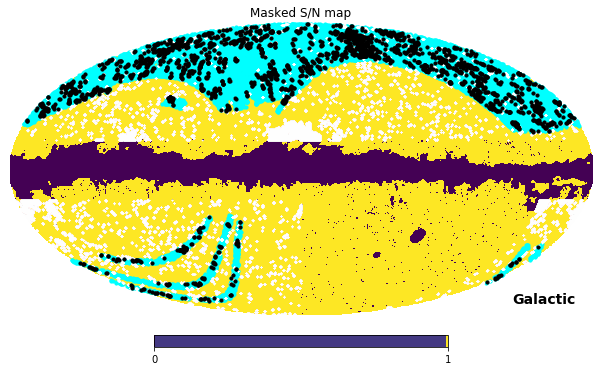

In [35]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='cyan',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)
hp.visufunc.projscatter(unionLons, unionLats,c='k',lonlat=True,s=10)

In [37]:
len(unionLons)

2470

---